# Adaptive noise cancellation demo

 This notebook demonstrates adaptive noise cancellation (ANC) techniques for removing power line interference from signals.
 
 The demo shows how to:
 - Generate synthetic data with power line noise
 - Apply adaptive RLS filtering to cancel the noise
 - Evaluate the filtering performance
 
 The code implements the algorithm described in ["Adaptive cancellation of mains power interference in continuous gravitational wave searches with a hidden Markov model"](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.110.122004)

 ---
 


## 0. Setup 

In [7]:
# %%
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import sys 
sys.path.append('../python/')


In [9]:
import numpy as np 
# A useful function for grabbing the spectrum (FT modulus) of a time series, and the associated frequencies
def get_spectrum(data, dt):
    fft_result = np.fft.fft(data)
    N = len(data)
    freq = np.fft.fftfreq(N, d=dt)


    magnitude_spectrum = np.abs(fft_result)

    # Note: The FFT is symmetric for real signals, so often you only want the positive frequencies
    # You can get these by:
    positive_freq = freq[:N//2]
    positive_magnitude = magnitude_spectrum[:N//2]
    
    return  positive_freq,positive_magnitude


## 1. Synthetic data 




In [10]:
import numpy as np 
from ANC.generate_synthetic_data import simulate_data
from ANC.hmm_viterbi import viterbi_for_ANC
from ANC.adaptive_filters import arls_n


# Generate simulated data
# The signal measured in the strain channel is x(t) = h(t) + c(t) + n(t)
# where h(t) is the GW signal, c(t) is the non-Gaussian interference, and n(t) is Gaussian noise.
# Separately, the reference signal is r(t) = A_ac * cos(2πf0t + θ(t)) + n_r(t)
# where A_ac is the amplitude of the reference signal, f0 is the central frequency, and θ(t) is the phase noise.
# See the paper for more details.

print("Generating simulated data")

## Sampling parameters 
W = 1000  # Sampling frequency
N = 2**14 # Number of samples per block
T = N/W   # Time within one block
Nb = 64  # Number of frequency blocks for simulated GW signal


## GW parameters 
sigma_f = 1  # Standard deviation of GW frequency
fq      = np.cumsum(np.concatenate(([59.5], sigma_f * np.sqrt(T) * np.random.randn(Nb-1)))) #array of random GW frequencies, see Equation 20 and 21 in paper. Note that the frequency updates are happing at the block level rather than every sample point.
h0      = 0.025   # GW signal amplitude


## Clutter parameters 
gamma_a     = 0.01    # Phase fluctuation parameter (related to 1/P in paper)
A_c         = 1.0    # Amplitude of clutter
sigma_theta = 0.01   # Standard deviation of phase noise (σΘ in paper)
Δfac        = 1.0    # Amplitude of phase modulation 
f_ac        = 60.0 # Hz, central frequency 


## Gaussian noise parameters 
sigma_n     = 1.0    # Standard deviation of Gaussian noise (strain channel)


## Reference signal parameters 
sigma_r     = 1e-2   # Standard deviation of reference signal measurement noise. 
A_r         = 10.0   # Amplitude of the reference 





x, r, injection, time = simulate_data(
                                    f_ac=f_ac,
                                    fq=fq, 
                                    h0=h0,
                                    sigma_n=sigma_n,
                                    W=W,
                                    N=N,
                                    sigma_r=sigma_r,
                                    A_c=A_c,
                                    A_r=A_r,
                                    gamma_a=gamma_a,
                                    Δfac=Δfac,
                                    sigma_theta=sigma_theta
)


# Apply RLS filter
print("Applying RLS filter")
lambda_val = 0.9999999999999999
order = 15
c_RLS, _, _,_= arls_n(x, r, order, lambda_val) # cancelled, adap, fit, P 


# # Evaluate using Viterbi
# print("Evaluating using Viterbi")
# score, _,_ = viterbi_for_ANC(gamma, s, N, Nb, T, W) #score, fhat, y0 
# score_RLS, _,_= viterbi_for_ANC(gamma, c_RLS, N, Nb, T, W)
    
 

Generating simulated data
Applying RLS filter


Processing samples: 100%|██████████| 1048576/1048576 [00:09<00:00, 110489.57it/s]


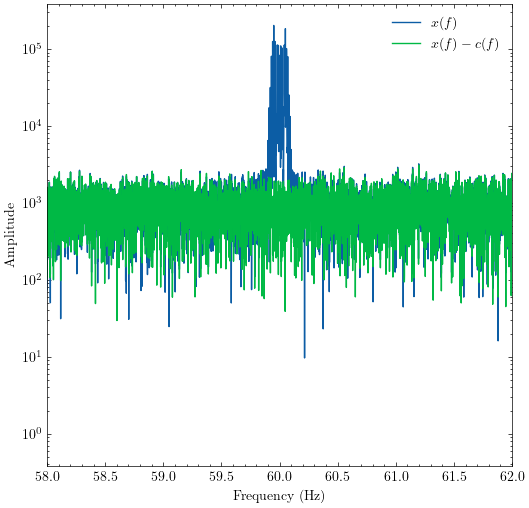

In [11]:
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use('science')

dt = time[1]-time[0]
fs = 1/dt

fig_dimension = 6
fig, ax = plt.subplots(figsize=(fig_dimension, fig_dimension))
labels = [r'$x(f)$',r'$x(f) - c(f)$']
for i, s in enumerate([x, c_RLS]):
    positive_freq, positive_magnitude = get_spectrum(s, dt)
    ax.plot(positive_freq, positive_magnitude,label = labels[i])

plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(58,62)
plt.legend()
plt.yscale('log')


## Real LIGO data 


Now lets look at real LIGO data from the actual detector. For this notebook we'll exlusively use publicly available data from the Gravitational Wave Open Science Center (GWOSC) at https://gwosc.org. GWOSC provides open access to LIGO data. We'll use the GWpy package to fetch and analyze this data.


Note that not all of the PEM data is publically available. Here we will use just the 3 channels available from the centtral station (`CS`) `L1:PEM-CS_MAINSMON_EBAY_*_DQ`. For those with LIGO access, the `EX` and `EY`channels can also be used. 


### 2.1 Coherence between strain and reference channels 

First load a segment of the strain data:

In [12]:
from gwpy.timeseries import TimeSeries


start_time = 1238166208
num_intervals = 10
end_time = start_time + 64*num_intervals


strain_data = TimeSeries.fetch('L1:DCS-CALIB_STRAIN_C01_AR', start=start_time, end=end_time, host='nds.gwosc.org')

Then load the PEM data:

In [13]:
#https://git.ligo.org/gwosc/tutorials/gwosc-aux-tutorials/-/blob/main/Channels/O3_bulk_aux_channel_list.csv
#Only 3 of the MAINSMON channels are available as open data for O3
L1_PEM_CHANNELS = ['L1:PEM-CS_MAINSMON_EBAY_1_DQ', 'L1:PEM-CS_MAINSMON_EBAY_2_DQ', 'L1:PEM-CS_MAINSMON_EBAY_3_DQ']
PEM_data_array = []
for channel in L1_PEM_CHANNELS:
    data = TimeSeries.fetch(channel, start=start_time, end=end_time, host='nds.gwosc.org')
    PEM_data_array.append(data)


In order to use filtering methods, we need there to be some coherence between the strain and PEM channels:

/opt/miniconda3/envs/ANC/lib/python3.10/site-packages/gwpy/signal/spectral/_scipy.py:223: UserWarning: Sampling frequencies are unequal. Higher frequency series will be downsampled before coherence is calculated
  warnings.warn("Sampling frequencies are unequal. Higher "


Text(0.5, 0, 'Frequency [Hz]')

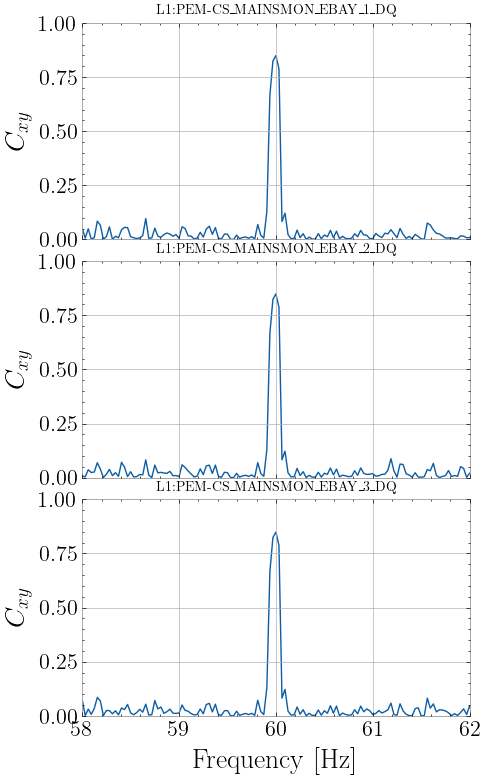

In [53]:
import matplotlib.pyplot as plt
import numpy as np 
import scienceplots
plt.style.use('science')

num_pem_channels = len(L1_PEM_CHANNELS)
fig, axes = plt.subplots(nrows=num_pem_channels, ncols=1, figsize=(5,9),sharex=True)
fs = 20
for i in range(num_pem_channels):

    #Coherence. See e.g. https://gwpy.github.io/docs/latest/examples/frequencyseries/coherence/
    coherence = strain_data.coherence(PEM_data_array[i], fftlength=2, overlap=1)


    #Extract values to give us more flexibility plotting 
    coherence_frequencies = np.array(coherence.frequencies)
    coherence_values = np.array(coherence)


    ax = axes[i]
    ax.plot(coherence_frequencies,coherence_values)


    ax.set_xlim(58, 62)
    ax.set_ylim(0, 1)

    ax.set_ylabel(r'$C_{xy}$',fontsize=fs)
    ax.axes.tick_params(axis="both", labelsize=fs-4)
    ax.set_title(L1_PEM_CHANNELS[i],fontsize=fs-10)


#Some extra formatting 
plt.subplots_adjust(hspace=0.1)  
axes[-1].set_xlabel(r'Frequency [Hz]',fontsize=fs)


There is a clear coherence feature at 60Hz, just where the mains power interference is.

### 2.2 Filtering


Now lets use the PEM data to filter the 60 Hz clutter from the strain channel.


To start, lets bandpass the data to the frequency range of interest (I am not sure if this is strictly necessary, but it seems like a reasonable step to take)

In [81]:
strain_data_bandpassed = strain_data#.bandpass(59,61)
PEM_data_bandpassed = PEM_data_array[0]#.bandpass(59,61)


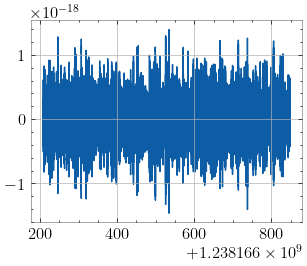

In [82]:
plt.plot(strain_data_bandpassed.times, strain_data_bandpassed.value)

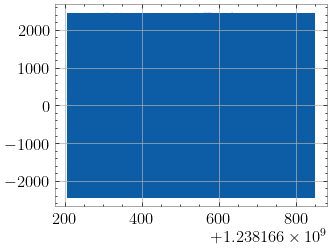

In [83]:
plt.plot(PEM_data_bandpassed.times, PEM_data_bandpassed.value)

In [105]:
# Apply RLS filter
print("Applying RLS filter")
lambda_val = 0.99
order = 36
print("calling arls_n")
c_RLS, _, _,_= arls_n(strain_data_bandpassed.value, PEM_data_bandpassed.value, order, lambda_val) # cancelled, adap, fit, P 

Applying RLS filter
calling arls_n


Processing samples: 100%|██████████| 655360/655360 [00:07<00:00, 82471.71it/s]


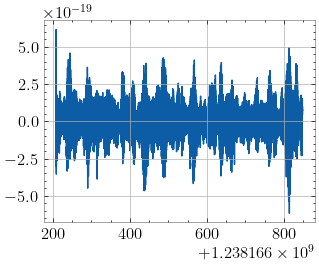

In [106]:
plt.plot(PEM_data_bandpassed.times, c_RLS)
#plt.xlim(PEM_data_bandpassed.times[0].value,PEM_data_bandpassed.times[100].value)


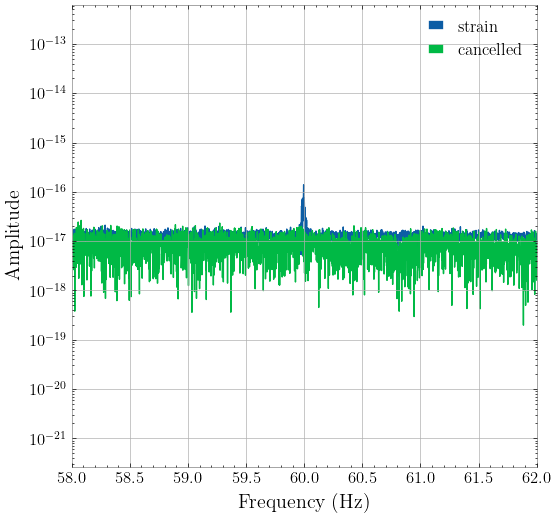

In [107]:
fig_dimension = 6
fig, ax = plt.subplots(figsize=(fig_dimension, fig_dimension))


positive_freq, positive_magnitude = get_spectrum(strain_data, strain_data.dt)
filtered_freq, filtered_magnitude = get_spectrum(c_RLS, PEM_data_bandpassed.dt)



ax.plot(positive_freq, positive_magnitude,label='strain')
ax.plot(filtered_freq, filtered_magnitude,label='cancelled')


plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(58,62)
#plt.ylim(5e-18,2e-16)
plt.legend()

plt.yscale('log')